<a href="https://colab.research.google.com/github/Mahendhar-Saratha/DigitCV/blob/main/Kaggle_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kaggle Challenge #3: Digit Classification**

**Mahendhar Saratha**

In this Kaggle challenge we will be working on a project that aims to solve the famous challenge of recognizing handwritten digits using the MNIST dataset. My goal is to create feed forward neural network and train models that can correctly identify and classify handwritten digit images

My approach to tackle the digit classification difficulty with the MNIST dataset combines theoretical insight and practical neural network implementation. First, we will concentrate on data preprocessing chores, which include importing the dataset and visually evaluating the photos based on their pixel values. We intend to create two separate neural network architectures: first, a bespoke model constructed with NumPy to obtain a better understanding of neural network foundations such as activation functions, dropout layers and optimization strategies. Second, we will create a model using the widely-used TensorFlow and Keras frameworks, which will facilitate a streamlined and expedited development process.

During the training phase, we will employ techniques such as early stopping to prevent overfitting and cross-validation to ensure that the models can generalize well to unseen data. The evaluation of these models will primarily focus on accuracy metrics and visual analyses of the training progress.

The project aims to build and train neural network models using two different approaches (low-level NumPy implementation and high-level TensorFlow/Keras implementation) to accurately classify handwritten digits from the MNIST dataset. The process involves data preparation, model development, training with techniques like early stopping and cross-validation, evaluation using accuracy metrics and visual analysis, and comparison of the two models to enhance overall performance.

Below facilitates the integration of Google Drive within the Google Colab environment

In [ ]:
from google.colab import drive

# Mounting Google Drive to the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


Importing nessesary libraries for low-level implementation and also importing libraries which are needed for Tensorflow and keras

In [ ]:
import numpy as np
import time
import pandas as pd
from numpy import genfromtxt
import matplotlib.pyplot as plt

## Packages for TensorFlow and Keras

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

## This is to avoid some warning messages in the output to show correct result
import warnings
warnings.filterwarnings('ignore')



Loading data datasets mnist_train.csv, mnist_train_targets.csv, and mnist_test.csv


**mnist_train.csv**: This file comprises training data.

**mnist_train_targets.csv**: It contains the actual numbers corresponding to the training data, which we use to assess accuracy.

**mnist_test.csv**: After training the model, we utilize this dataset to predict the numbers based on the pixel values.

In [ ]:
training_set =pd.read_csv('/content/drive/MyDrive/Kaggle3/mnist_train.csv')
training_label_set =pd.read_csv('/content/drive/MyDrive/Kaggle3/mnist_train_targets.csv')
test_set =pd.read_csv('/content/drive/MyDrive/Kaggle3/mnist_test.csv')

Visualizing Training data pixel samples

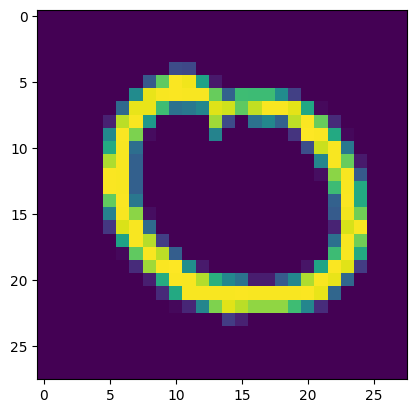

In [ ]:
train_values=training_set['V99']
image_array=train_values.to_numpy().reshape((28,28))
plt.imshow(image_array)

Visualizing Test data pixel samples

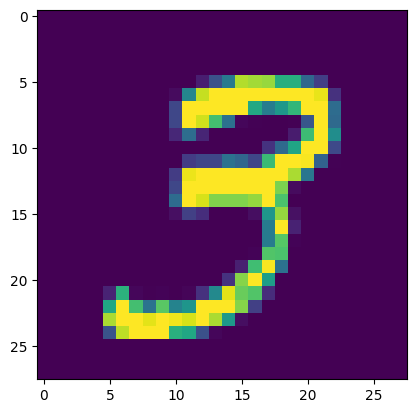

In [ ]:
test_values=test_set['V1']
image_array=test_values.to_numpy().reshape((28,28))
plt.imshow(image_array)

**CommonMethods** class is like a common class which contains methods which will be shared across different implementations like Original Neural Network and Neural Network with Drop out Layer and also Adam Optimizer implementation.

In [ ]:
class CommonMethods:

    def __init__(self,initial_row=1):
        self.current_row = initial_row

    def write_to_csv(self, predictions):
        filepath = '/content/drive/MyDrive/Kaggle3/submission.csv'
        with open(filepath, 'a') as f:
            f.write("Id,Expected\n")
            for value in predictions:
                f.write(f"{self.current_row},{value}\n")
                self.current_row += 1

    def softmax(self, x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps, axis=0)

    def sigmoid(self, x, derivative=False):
        sig = 1 / (1 + np.exp(-x))
        return sig * (1 - sig) if derivative else sig


**Implementaion of feed forward Neural Network with 2 Hidden Layers**

Created NeuralNetwork class capable of training on labeled data for classification tasks. Intialized network parameters such as layer sizes, number of epochs, and learning rate, and initialized weights randomly. Included methods for forward and backward passes through the network, applying activation functions such as sigmoid  and softmax, and updating weights using backpropagation. It also added functionality for training the network on input-output pairs, computing accuracy, and writing predictions to a CSV file. The training process involves preprocessing input data and normalization as well, computing target outputs based on labels, and iterating through epochs to adjust weights until a certain accuracy threshold is met.

In [ ]:

class NeuralNetwork:
    def __init__(self, layer_sizes, num_epochs, learning_rate, initial_row=1):
        self.layer_sizes = layer_sizes
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.current_row = initial_row
        self.common=CommonMethods()

        # Initialize weights
        self.weights = {
            'W1': np.random.randn(layer_sizes[1], layer_sizes[0]) * np.sqrt(1. / layer_sizes[1]),
            'W2': np.random.randn(layer_sizes[2], layer_sizes[1]) * np.sqrt(1. / layer_sizes[2]),
            'W3': np.random.randn(layer_sizes[3], layer_sizes[2]) * np.sqrt(1. / layer_sizes[3]),
        }


    ## This method do the prediction for the test values
    def predictions(self, test_data):
        predictions = []
        count = 0
        for x in test_data:
            all_values = test_data[x]
            ## scale and shift the inputs
            inputs = (np.asfarray(all_values) / 255.0 * 0.99) + 0.01
            ## Doing a forward pass for the data
            output = self.forward_pass(inputs)
            ## once forwatd pass is done , Predicted output will have highest value among others, just taking that value
            pred = np.argmax(output)
            ## Now appending that predicted value into the list
            predictions.append(pred)
            count+=1
        return predictions

    ## This is the forward propagation method
    def forward_pass(self, x):
        self.activations = {'A0': x}
        ## Assuming 3 layers + output layer
        for i in range(1, 4):
            ## Computes the linear transformation for the current layer using the weights matrix W and activations from the previous layer.
            self.activations[f'Z{i}'] = np.dot(self.weights[f'W{i}'], self.activations[f'A{i-1}'])
            ## Chooses the activation function for the current layer. ReLU is used for hidden layers and softmax is used for the output layer
            activation_function = self.common.sigmoid if i < 3 else self.common.softmax
            ## Aplying the choosed activation function
            self.activations[f'A{i}'] = activation_function(self.activations[f'Z{i}'])
        return self.activations['A3']

    def backward_pass(self, y, output):
        deltas = {}
        ## Computing the error at the output layer
        error = (output - y) / output.shape[0]
        ## Computing the gradient of the loss function with respect to the weights of the output layer.
        deltas['W3'] = np.outer(error, self.activations['A2'])

        # Propagate error back through network
        for i in range(2, 0, -1):
            ## Computes the error at the layer using the error from the next layer, the weights connecting the next layer to the current layer
            error = np.dot(self.weights[f'W{i+1}'].T, error) * self.common.sigmoid(self.activations[f'Z{i}'], derivative=True)
            ## Computes the gradient of the loss function with respect to the weights of layer
            deltas[f'W{i}'] = np.outer(error, self.activations[f'A{i-1}'])
        return deltas

    ## Updates weights values using the gradient descent update rule
    def update_parameters(self, deltas):
        for key in self.weights.keys():
            self.weights[key] -= self.learning_rate * deltas[key]

    def train(self, train_list, test_list, output_nodes,train_label):
        start_time = time.time()
        final_data={}
        epoch_data=[]
        time_data=[]
        accuracy_data=[]
        for iteration in range(self.num_epochs):
            count = 0
            for x in train_list:
                all_values = train_list[x]
                ## scale and shift the inputs
                inputs = (np.asfarray(all_values) / 255.0 * 0.99) + 0.01
                ## create the target output values (all 0.01, except the desired label which is 0.99)
                targets = np.zeros(output_nodes) + 0.01
                ## train_label[count] is the target label for this record
                targets[int(train_label[count])] = 0.99
                output = self.forward_pass(inputs)
                changes_to_w = self.backward_pass(targets, output)
                self.update_parameters(changes_to_w)
                count += 1


            if(True):
                accuracy = self.compute_accuracy(training_set, output_nodes,train_label)
                final_data[iteration + 1]=accuracy * 100
                epoch_data.append(iteration + 1)
                time_data.append(time.time())
                accuracy_data.append(accuracy * 100)
                print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(iteration + 1, time.time() - start_time, accuracy * 100))
                if(accuracy * 100 > 92):
                    break
        return (final_data,epoch_data,time_data,accuracy_data)

    def compute_accuracy(self, test_data, output_nodes,train_label):
        predictions = []
        count = 0
        for x in test_data:
            all_values = test_data[x]
            ## scaling and shifting the inputs
            inputs = (np.asfarray(all_values) / 255.0 * 0.99) + 0.01
            ## create the target output values (all 0.01, except the desired label which is 0.99)
            targets = np.zeros(output_nodes) + 0.01
            ## Taking actual output value from train label and assigning value 0.99
            targets[int(train_label[count])] = 0.99
            output = self.forward_pass(inputs)
            ## once forwatd pass is done , Predicted output will have highest value among others, just taking that value
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(targets))
            count+=1

        return np.mean(predictions)


In [ ]:
dnn = NeuralNetwork(layer_sizes=[784, 128, 64, 10], num_epochs=200, learning_rate=0.001)
(final_data,epoch_data,time_data,accuracy_data)=dnn.train(training_set, test_set, 10,training_label_set.to_numpy())
predictions=dnn.predictions(test_set)
dnn.common.write_to_csv(predictions)

<ipython-input-8-95c6bb9bb9f8>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  targets[int(train_label[count])] = 0.99
<ipython-input-8-95c6bb9bb9f8>:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  targets[int(train_label[count])] = 0.99


Epoch: 1, Time Spent: 76.77s, Accuracy: 61.25%
Epoch: 2, Time Spent: 149.52s, Accuracy: 68.98%
Epoch: 3, Time Spent: 223.01s, Accuracy: 73.11%
Epoch: 4, Time Spent: 296.66s, Accuracy: 76.37%
Epoch: 5, Time Spent: 369.95s, Accuracy: 78.83%
Epoch: 6, Time Spent: 443.49s, Accuracy: 80.61%
Epoch: 7, Time Spent: 515.48s, Accuracy: 81.97%
Epoch: 8, Time Spent: 587.79s, Accuracy: 83.02%
Epoch: 9, Time Spent: 662.04s, Accuracy: 83.75%
Epoch: 10, Time Spent: 735.57s, Accuracy: 84.48%
Epoch: 11, Time Spent: 808.56s, Accuracy: 85.06%
Epoch: 12, Time Spent: 881.57s, Accuracy: 85.56%
Epoch: 13, Time Spent: 954.77s, Accuracy: 85.97%
Epoch: 14, Time Spent: 1027.89s, Accuracy: 86.30%
Epoch: 15, Time Spent: 1100.16s, Accuracy: 86.65%
Epoch: 16, Time Spent: 1172.17s, Accuracy: 86.89%
Epoch: 17, Time Spent: 1245.81s, Accuracy: 87.15%
Epoch: 18, Time Spent: 1321.50s, Accuracy: 87.40%
Epoch: 19, Time Spent: 1394.65s, Accuracy: 87.56%
Epoch: 20, Time Spent: 1468.35s, Accuracy: 87.76%
Epoch: 21, Time Spent: 

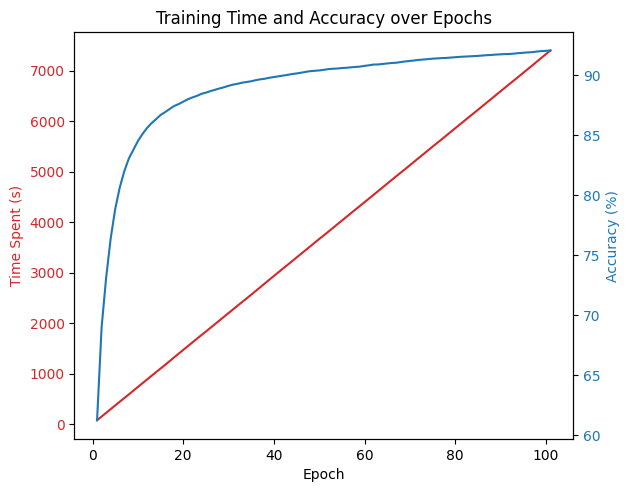

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Time Spent (s)', color=color)
ax1.plot(epoch_data, time_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(epoch_data, accuracy_data, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Time and Accuracy over Epochs')
plt.show()


I created a neural network featuring two hidden layers aimed at classifying handwritten digits sourced from the MNIST dataset. I conducted training using bespoke forward and backward propagation functions on normalized data. Upon submission to Kaggle, my model demonstrated robust predictive capability, achieving an accuracy score of 0.92 with 100 Iterations, I have went ahead to add drop out mechanism to see the accuracy.

**Introducing Drop Out Layer**

We implemented dropout, a regularization technique, to combat overfitting in our neural network model. Dropout randomly zeros out a fraction of the output features of a layer during the training phase. The dropout rate- a hyperparameter, determines the probability of an element being set to zero. Our implementation involved initializing dropout rates for each layer and storing them in a dictionary during the neural network's initialization. We then modified the forward_pass function to incorporate dropout after the activation of each hidden layer, ensuring dropout was applied only during training and not during evaluation or prediction phases.

In [ ]:
class NeuralNetworkDropOut:
    def __init__(self, layer_sizes, num_epochs, learning_rate, dropout_rates=None, initial_row=1):
        self.layer_sizes = layer_sizes
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.dropout_rates = dropout_rates if dropout_rates is not None else {}
        self.current_row = initial_row
        self.common=CommonMethods()

        ## Initialize weights
        self.weights = {
            'W1': np.random.randn(layer_sizes[1], layer_sizes[0]) * np.sqrt(1. / layer_sizes[1]),
            'W2': np.random.randn(layer_sizes[2], layer_sizes[1]) * np.sqrt(1. / layer_sizes[2]),
            'W3': np.random.randn(layer_sizes[3], layer_sizes[2]) * np.sqrt(1. / layer_sizes[3]),
        }


    def forward_pass(self, x, training=False):
        self.activations = {'A0': x}
        for i in range(1, 4):  ## Assuming 3 layers + output layer
            self.activations[f'Z{i}'] = np.dot(self.weights[f'W{i}'], self.activations[f'A{i-1}'])
            ## Using Sigmoid for hidden layers and softmax for output layer
            activation_function = self.common.sigmoid if i < 3 else self.common.softmax
            self.activations[f'A{i}'] = activation_function(self.activations[f'Z{i}'])

            ## Applying dropout if in training mode and dropout rate is specified for the layer
            if training and i < 3 and i in self.dropout_rates:
                dropout_mask = np.random.rand(*self.activations[f'A{i}'].shape) > self.dropout_rates[i]
                ## Scale activations to maintain expected value
                self.activations[f'A{i}'] *= dropout_mask / (1 - self.dropout_rates[i])
        return self.activations['A3']

    def backward_pass(self, y, output):
        deltas = {}
        ## Output layer error
        error = (output - y) / output.shape[0]
        deltas['W3'] = np.outer(error, self.activations['A2'])

        ## Propagating error back through network
        for i in range(2, 0, -1):
            error = np.dot(self.weights[f'W{i+1}'].T, error) * self.common.sigmoid(self.activations[f'Z{i}'], derivative=True)
            deltas[f'W{i}'] = np.outer(error, self.activations[f'A{i-1}'])
        return deltas

    def update_parameters(self, deltas):
        for key in self.weights.keys():
            self.weights[key] -= self.learning_rate * deltas[key]


    def train(self, train_list, test_list, output_nodes,train_label):
        start_time = time.time()
        final_data={}
        epoch_data=[]
        time_data=[]
        accuracy_data=[]
        for iteration in range(self.num_epochs):
            count = 0
            for x in train_list:
                all_values = train_list[x]
                ## scale and shift the inputs
                inputs = (np.asfarray(all_values) / 255.0 * 0.99) + 0.01
                ## create the target output values (all 0.01, except the desired label which is 0.99)
                targets = np.zeros(output_nodes) + 0.01
                ## train_label[count] is the target label for this record
                targets[int(train_label[count])] = 0.99
                output = self.forward_pass(inputs)
                changes_to_w = self.backward_pass(targets, output)
                self.update_parameters(changes_to_w)
                count += 1


            if(True):
                accuracy = self.compute_accuracy(training_set, output_nodes,train_label)
                final_data[iteration + 1]=accuracy * 100
                epoch_data.append(iteration + 1)
                time_data.append(time.time())
                accuracy_data.append(accuracy * 100)
                print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(iteration + 1, time.time() - start_time, accuracy * 100))
                if(accuracy * 100 > 92):
                     break
        return (final_data,epoch_data,time_data,accuracy_data)

    def compute_accuracy(self, test_data, output_nodes,train_label):
        predictions = []
        count = 0
        for x in test_data:
            all_values = test_data[x]
            ## scaling and shifting the inputs
            inputs = (np.asfarray(all_values) / 255.0 * 0.99) + 0.01
            ## create the target output values (all 0.01, except the desired label which is 0.99)
            targets = np.zeros(output_nodes) + 0.01
            ## Taking actual output value from train label and assigning value 0.99
            targets[int(train_label[count])] = 0.99
            output = self.forward_pass(inputs)
            ## once forwatd pass is done , Predicted output will have highest value among others, just taking that value
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(targets))
            count+=1

        return np.mean(predictions)


    ## This method do the prediction for the test values
    def predictions(self, test_data):
        predictions = []
        count = 0
        for x in test_data:
            all_values = test_data[x]
            ## scale and shift the inputs
            inputs = (np.asfarray(all_values) / 255.0 * 0.99) + 0.01
            ## Doing a forward pass for the data
            output = self.forward_pass(inputs)
            ## once forwatd pass is done , Predicted output will have highest value among others, just taking that value
            pred = np.argmax(output)
            ## Now appending that predicted value into the list
            predictions.append(pred)
            count+=1
        return predictions

In [ ]:
dnn = NeuralNetworkDropOut(layer_sizes=[784, 128, 64, 10], num_epochs=20, learning_rate=0.01)
(final_data,epoch_data,time_data,accuracy_data)=dnn.train(training_set, test_set, 10,training_label_set.to_numpy())
predictions=dnn.predictions(test_set)
dnn.common.write_to_csv(predictions)

<ipython-input-15-a386f5b42f8b>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  targets[int(train_label[count])] = 0.99
<ipython-input-15-a386f5b42f8b>:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  targets[int(train_label[count])] = 0.99


Epoch: 1, Time Spent: 66.61s, Accuracy: 85.08%
Epoch: 2, Time Spent: 128.68s, Accuracy: 87.79%
Epoch: 3, Time Spent: 192.74s, Accuracy: 88.67%
Epoch: 4, Time Spent: 253.80s, Accuracy: 89.02%
Epoch: 5, Time Spent: 314.91s, Accuracy: 89.49%
Epoch: 6, Time Spent: 378.56s, Accuracy: 90.00%
Epoch: 7, Time Spent: 439.44s, Accuracy: 90.57%
Epoch: 8, Time Spent: 500.36s, Accuracy: 90.92%
Epoch: 9, Time Spent: 563.14s, Accuracy: 91.27%
Epoch: 10, Time Spent: 625.60s, Accuracy: 91.50%
Epoch: 11, Time Spent: 687.17s, Accuracy: 91.77%
Epoch: 12, Time Spent: 749.52s, Accuracy: 91.97%
Epoch: 13, Time Spent: 812.41s, Accuracy: 92.18%
Epoch: 14, Time Spent: 873.79s, Accuracy: 92.41%
Epoch: 15, Time Spent: 936.12s, Accuracy: 92.65%
Epoch: 16, Time Spent: 999.74s, Accuracy: 92.90%
Epoch: 17, Time Spent: 1061.14s, Accuracy: 93.16%
Epoch: 18, Time Spent: 1123.71s, Accuracy: 93.39%
Epoch: 19, Time Spent: 1186.57s, Accuracy: 93.64%
Epoch: 20, Time Spent: 1248.14s, Accuracy: 93.86%


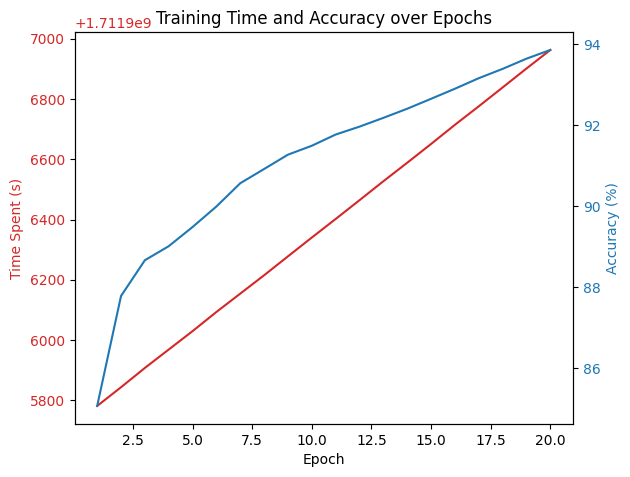

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Time Spent (s)', color=color)
ax1.plot(epoch_data, time_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(epoch_data, accuracy_data, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Time and Accuracy over Epochs')
plt.show()

By integrating Dropout, we reached a 0.92 accuracy in just 9 epochs, significantly reducing the time and iterations required compared to the previous approach. Additionally, with 100 epochs, we attained an accuracy of 0.97, demonstrating the effectiveness of Dropout in accelerating convergence and improving model performance.

**Introducing Adam Optimizer**

In [ ]:
class NeuralNetworkAdamOptimizerNew(NeuralNetworkDropOut):
    def __init__(self, layer_sizes, num_epochs, learning_rate, dropout_rates=None):
        super().__init__(layer_sizes,num_epochs,learning_rate)

        ## Initialize weights and Adam parameters
        self.weights = {}
        self.m = {}
        self.v = {}
        self.t = 0  ## Adam timestep

        for i in range(1, len(layer_sizes)):
            self.weights[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * np.sqrt(1. / layer_sizes[i])
            self.m[f'W{i}'] = np.zeros_like(self.weights[f'W{i}'])
            self.v[f'W{i}'] = np.zeros_like(self.weights[f'W{i}'])


    def update_parameters(self, deltas):
        self.t += 1  ## Increment timestep
        alpha = self.learning_rate
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8

        for key in self.weights.keys():
            ## Biased first moment estimate
            self.m[key] = beta1 * self.m[key] + (1 - beta1) * deltas[key]
            ## Biased second raw moment estimate
            self.v[key] = beta2 * self.v[key] + (1 - beta2) * (deltas[key] ** 2)

            ## Bias-corrected first moment estimate
            m_corrected = self.m[key] / (1 - beta1 ** self.t)
            ## Bias-corrected second raw moment estimate
            v_corrected = self.v[key] / (1 - beta2 ** self.t)

            ## Update weights
            self.weights[key] -= alpha * m_corrected / (np.sqrt(v_corrected) + epsilon)



In [ ]:
dnn = NeuralNetworkAdamOptimizerNew(layer_sizes=[784, 128, 64, 10], num_epochs=10, learning_rate=0.001)
(final_data,epoch_data,time_data,accuracy_data)=dnn.train(training_set, test_set, 10,training_label_set.to_numpy())
predictions=dnn.predictions(test_set)


In [ ]:
dnn.common.write_to_csv(predictions)

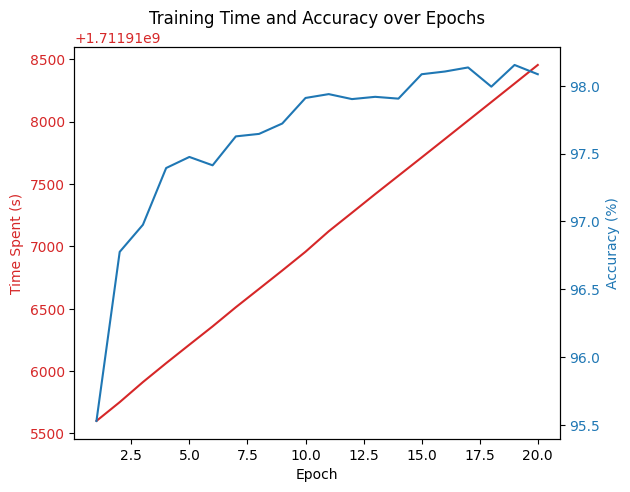

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Time Spent (s)', color=color)
ax1.plot(epoch_data, time_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(epoch_data, accuracy_data, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Time and Accuracy over Epochs')
plt.show()

By integrating Adam Optimizer, we reached a 0.95 accuracy in just 1 epoch, significantly reducing the time and iterations required compared to the previous two approaches. Additionally, with 4 epochs, we attained an accuracy of 0.98, demonstrating the effectiveness of Adam Optimizer in accelerating convergence and improving model performance.

**Implementation using TensorFlow and Keras**

In [ ]:
x_train = training_set.T.to_numpy()
x_train=x_train.reshape(-1,28,28,1)/255.0
y_train = training_label_set.astype(np.int32)
y_train = to_categorical(y_train)
x_test = test_set.T.to_numpy()
x_test=x_test.reshape(-1,28,28,1)/255.0
number_of_class = y_train.shape[1]

In [ ]:
## Create CNN networking architecture

model = Sequential()

model.add(Conv2D(input_shape = (28,28,1), filters = 16, kernel_size = (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(filters = 128, kernel_size = (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())


model.add(Flatten())
model.add(Dense(units = 256))
model.add(Activation("relu"))


model.add(Dropout(0.2))
model.add(Dense(units = number_of_class))
model.add(Activation("softmax"))


model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

hist = model.fit(x_train,y_train, epochs= 10, batch_size= 128,verbose=0)

In [ ]:
y_test= model.predict(x_test)

predicted_labels = np.argmax(y_test, axis=1)

print(predicted_labels)
line_numbers=range(1,10001)

df = pd.DataFrame({'Id':line_numbers,'Expected':predicted_labels})

## Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/Kaggle3/submission_keras_file.csv', index=False)

y_test=predicted_labels

y_test = y_test.astype(np.int32)

y_test = to_categorical(y_test)

313/313 [==============================] - 3s 10ms/step
[3 4 1 ... 1 2 8]


In [ ]:
hist = model.fit(x_train,y_train, validation_data=(x_test,y_test), epochs= 10, batch_size= 128)

Epoch 1/10
469/469 [==============================] - 49s 105ms/step - loss: 0.0096 - accuracy: 0.9966 - val_loss: 0.0820 - val_accuracy: 0.9788
Epoch 2/10
469/469 [==============================] - 51s 110ms/step - loss: 0.0104 - accuracy: 0.9965 - val_loss: 0.0787 - val_accuracy: 0.9803
Epoch 3/10
469/469 [==============================] - 48s 103ms/step - loss: 0.0093 - accuracy: 0.9971 - val_loss: 0.0819 - val_accuracy: 0.9822
Epoch 4/10
469/469 [==============================] - 52s 111ms/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.0922 - val_accuracy: 0.9802
Epoch 5/10
469/469 [==============================] - 49s 104ms/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 0.0831 - val_accuracy: 0.9835
Epoch 6/10
469/469 [==============================] - 50s 107ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.0690 - val_accuracy: 0.9842
Epoch 7/10
469/469 [==============================] - 48s 103ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.1026 - val_ac

**Plotting**

In [ ]:
print(hist.history)

{'loss': [0.009557198733091354, 0.01044089999049902, 0.009279709309339523, 0.0068063740618526936, 0.00898045115172863, 0.007392544765025377, 0.006131453905254602, 0.007243761792778969, 0.004844170995056629, 0.008312138728797436], 'accuracy': [0.9965999722480774, 0.9965166449546814, 0.997083306312561, 0.9979000091552734, 0.9970166683197021, 0.9975833296775818, 0.9980000257492065, 0.9977333545684814, 0.9983500242233276, 0.9972000122070312], 'val_loss': [0.08202453702688217, 0.07869821041822433, 0.08191785961389542, 0.09224794805049896, 0.08308900147676468, 0.0690409317612648, 0.10258805006742477, 0.07150589674711227, 0.12779077887535095, 0.10150738805532455], 'val_accuracy': [0.9787999987602234, 0.9803000092506409, 0.982200026512146, 0.9801999926567078, 0.9835000038146973, 0.9842000007629395, 0.9803000092506409, 0.9854000210762024, 0.9789999723434448, 0.9811999797821045]}


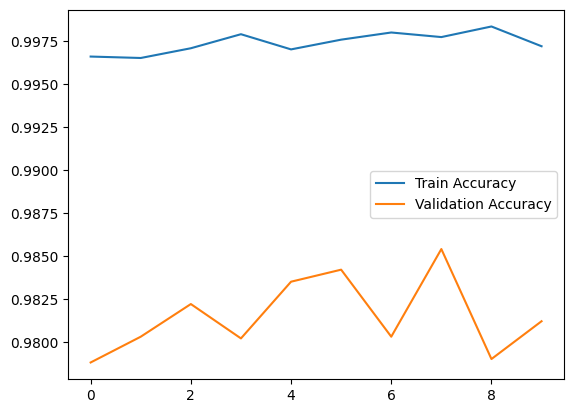

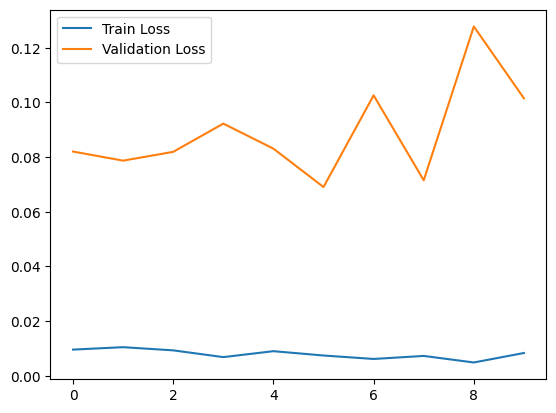

In [ ]:
plt.plot(hist.history["accuracy"],label="Train Accuracy")
plt.plot(hist.history["val_accuracy"],label="Validation Accuracy")
plt.legend()

plt.figure()
plt.plot(hist.history["loss"],label="Train Loss")
plt.plot(hist.history["val_loss"],label="Validation Loss")
plt.legend()

The model performs well in terms of accuracy on training data but less consistently on new, unseen data. This contradiction shows that the model may not perform well when encountering data from which it has not yet learned. The loss curve illustrates that the model has a low error rate for training data but a rising error rate for new data. The growing inaccuracy for fresh data over time could indicate that the model is overly focused on the training data, So it is overfitting. To address this, we will be implementing Early Stoppage

**Implementation using TensorFlow and Keras with Early stoppage to avoid Overfitting**

In [ ]:
## Create CNN networking architecture

model = Sequential()

## Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  ## Monitor the validation loss
    patience=3,          ## Number of epochs with no improvement after which training will be stopped
    verbose=1,           ## Will print messages when early stopping triggers
    restore_best_weights=True  ## Restores model weights from the epoch with the best value of the monitored quantity
)

model.add(Conv2D(input_shape = (28,28,1), filters = 16, kernel_size = (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(filters = 128, kernel_size = (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())


model.add(Flatten())
model.add(Dense(units = 256))
model.add(Activation("relu"))


model.add(Dropout(0.2))
model.add(Dense(units = number_of_class))
model.add(Activation("softmax"))


## Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

hist = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/20
375/375 [==============================] - 44s 112ms/step - loss: 0.1925 - accuracy: 0.9417 - val_loss: 1.1457 - val_accuracy: 0.5836
Epoch 2/20
375/375 [==============================] - 42s 111ms/step - loss: 0.0609 - accuracy: 0.9811 - val_loss: 0.0635 - val_accuracy: 0.9818
Epoch 3/20
375/375 [==============================] - 40s 105ms/step - loss: 0.0443 - accuracy: 0.9859 - val_loss: 0.0532 - val_accuracy: 0.9857
Epoch 4/20
375/375 [==============================] - 39s 105ms/step - loss: 0.0326 - accuracy: 0.9888 - val_loss: 0.0587 - val_accuracy: 0.9847
Epoch 5/20
375/375 [==============================] - 40s 107ms/step - loss: 0.0248 - accuracy: 0.9917 - val_loss: 0.0521 - val_accuracy: 0.9855
Epoch 6/20
375/375 [==============================] - 40s 107ms/step - loss: 0.0201 - accuracy: 0.9937 - val_loss: 0.0635 - val_accuracy: 0.9835
Epoch 7/20
375/375 [==============================] - 40s 106ms/step - loss: 0.0184 - accuracy: 0.9937 - val_loss: 0.0595 - val_ac

In [ ]:

y_test= model.predict(x_test)

predicted_labels = np.argmax(y_test, axis=1)

print(predicted_labels)

line_numbers=range(1,10001)

df = pd.DataFrame({'Id':line_numbers,'Expected':predicted_labels})

## Save the dataframe to a CSV file
df.to_csv('predicted_values.csv', index=False)


y_test=predicted_labels

y_test = y_test.astype(np.int32)

y_test = to_categorical(y_test)

313/313 [==============================] - 3s 9ms/step
[3 4 1 ... 1 2 8]


In [ ]:
hist = model.fit(x_train,y_train, validation_data=(x_test,y_test), epochs= 15, batch_size= 32)

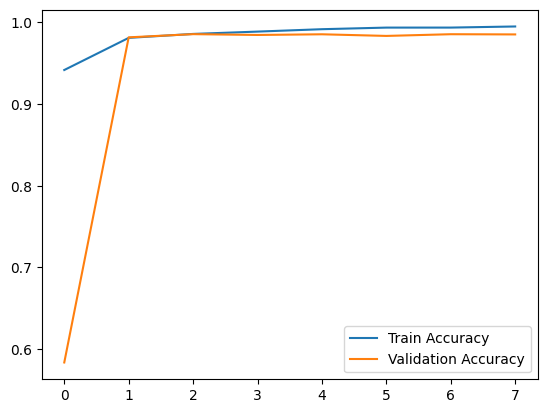

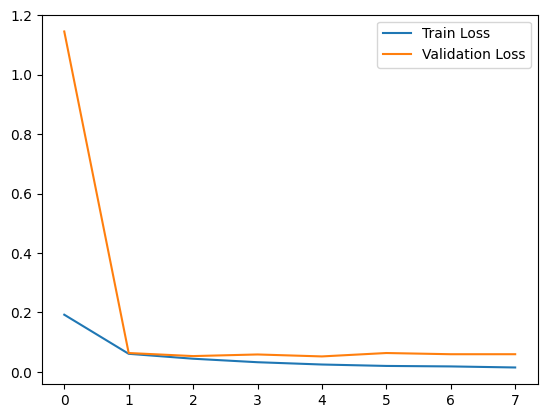

In [ ]:
plt.plot(hist.history["accuracy"],label="Train Accuracy")
plt.plot(hist.history["val_accuracy"],label="Validation Accuracy")
plt.legend()

plt.figure()
plt.plot(hist.history["loss"],label="Train Loss")
plt.plot(hist.history["val_loss"],label="Validation Loss")
plt.legend()


Implementing early stopping has resulted in higher validation accuracy and a smaller gap between training and validation loss. This means that the model is less overfitted and can better generalize to new data. The early stopping effectively terminated training before the model could memorize the training data, resulting in more stable and consistent validation measures. Overall, early halting has improved the model's capacity to perform well on fresh, previously unknown data while avoiding overfitting, boosting the model's dependability and robustness.

**K-Fold Cross-Validation for Neural Network Training on MNIST Dataset (TensorFlow and Keras)**

In [ ]:

# Parameters
number_of_folds = 5
number_of_class = 10  # Adjust based on your dataset

# K-Fold Cross-Validation
kf = KFold(n_splits=number_of_folds, shuffle=True, random_state=42)

# To store scores for each fold
scores = []

for train_index, val_index in kf.split(x_train):
    # Splitting Data
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Defining the model (this should be inside the loop to reset the model weights)
    model = Sequential([
        Conv2D(input_shape=(28,28,1), filters=16, kernel_size=(3,3)),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D(),

        Conv2D(filters=64, kernel_size=(3,3)),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D(),

        Conv2D(filters=128, kernel_size=(3,3)),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D(),

        Flatten(),
        Dense(units=256),
        Activation("relu"),

        Dropout(0.2),
        Dense(units=number_of_class),
        Activation("softmax")
    ])

    # Compile the model
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

    # Train the model
    hist=model.fit(x_train_fold, y_train_fold, batch_size=32, epochs=20, verbose=0)

    # Evaluate the model on the validation set
    score = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    scores.append(score[1])  # Assuming you want to track accuracy. Use score[0] for loss if desired.


# Calculate average score across all folds
average_score = np.mean(scores)
print(f"Average accuracy across {number_of_folds} folds: {average_score}")


Average accuracy across 5 folds: 0.9873166680335999


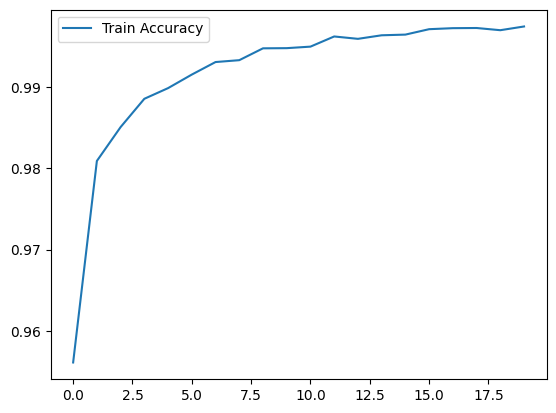

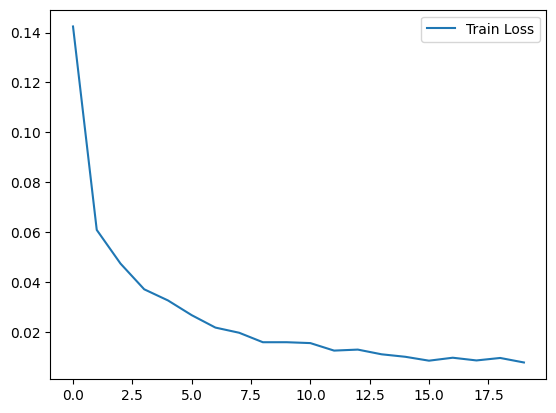

In [ ]:
plt.plot(hist.history["accuracy"],label="Train Accuracy")
plt.legend()

plt.figure()
plt.plot(hist.history["loss"],label="Train Loss")
plt.legend()

Getting a 0.988 score using K-Fold cross-validation is better than a 0.985 score achieved through early stopping. This highlights how K-Fold cross-validation helps improve the model's ability to perform well on new, unseen data. By dividing the data into different parts for training and testing, this technique makes sure the model's success isn't just based on one way of splitting the data. This reduces the risk of the model being too tailored to the training data (overfitting) and results in a model that's more dependable and strong when it comes to new data.

**Conclusion:**



We started with a simple neural network to classify MNIST handwritten digits and achieved 0.92 accuracy by employing two hidden layers and custom training loops on normalized data. To improve, we used Dropout, a strategy that randomly ignores some neurons during training, which not only kept the accuracy at 0.92 in fewer epochs but also increased it to 0.97 with extended training. Next, we have used the Adam Optimizer, a sophisticated algorithm that optimizes learning rates for each parameter, increasing efficiency and achieving 0.95 accuracy in just one epoch and 0.97 in four epochs and with 20 epochs we reached to 0.98.

We implemented using TensorFlow and Keras and got 0.98 accuracy. However, our initial model suffered from overfitting, performing well on training data but not on new, unknown data. This was demonstrated by the divergent loss curves for training and new data. To address this issue, we created Early Stopping, which halts training when the model stops improving on a validation dataset. This considerably enhanced our model's capacity to generalize, as indicated by increased validation accuracy and a smaller difference between training and validation loss. Each refinement step—Dropout, Adam Optimizer, Early Stopping—was critical in improving our model's accuracy, efficiency, and generalizability, demonstrating the value of these strategies in neural network optimization and training, With a decent accuracy, following modifications and the use of K-Fold cross-validation resulted in a notable final score of 0.98 on Kaggle.